In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from keras import backend as K

### Import data and pre-processing

In [3]:
# read csv files
raw_train_data = pd.read_csv('Data/train.csv')
raw_train_data = raw_train_data.drop(['id', 'onpromotion'], axis = 1)

In [5]:
#raw_train_data.head()

,date,store_nbr,family,sales
0,2013-01-01,1,AUTOMOTIVE,0.0
1,2013-01-01,1,BABY CARE,0.0
2,2013-01-01,1,BEAUTY,0.0
3,2013-01-01,1,BEVERAGES,0.0
4,2013-01-01,1,BOOKS,0.0


In [7]:
# let date beome index
raw_train_data['date'] = pd.to_datetime(raw_train_data['date'])
raw_train_data.set_index('date', inplace=True)

In [8]:
ordinal_encoder = OrdinalEncoder(dtype=int)
raw_train_data[['family']] = ordinal_encoder.fit_transform(raw_train_data[['family']])

In [9]:
raw_train_data.head()

,store_nbr,family,sales
date,,,
2013-01-01,1,0,0.0
2013-01-01,1,1,0.0
2013-01-01,1,2,0.0
2013-01-01,1,3,0.0
2013-01-01,1,4,0.0


In [20]:
# split raw_train_data into 2 parts: train_data and valid_data
train_data = raw_train_data['2017-03-19' : '2017-07-30'].copy()
valid_data = raw_train_data['2017-07-31':].copy()

In [22]:
# get a list of time series from train_data
train_list_of_ts = []

for i in range(1, 55):
    for j in range(33):
        train_store_i_family_j = train_data[(train_data['store_nbr']==i)&(train_data['family']==j)]
        train_list_of_ts =train_list_of_ts + [pd.DataFrame(train_store_i_family_j['sales'])]

In [23]:
# take the first element as example
train_list_of_ts[0]

,sales
date,
2017-03-19,1.0
2017-03-20,3.0
2017-03-21,8.0
2017-03-22,3.0
2017-03-23,3.0
...,...
2017-07-26,2.0
2017-07-27,5.0
2017-07-28,7.0


In [24]:
# get a list of time series from train_data
valid_list_of_ts = []

for i in range(1, 55):
    for j in range(33):
        valid_store_i_family_j = valid_data[(valid_data['store_nbr']==i)&(valid_data['family']==j)]
        valid_list_of_ts = valid_list_of_ts + [pd.DataFrame(valid_store_i_family_j['sales'])]

In [25]:
# take the first element as example
valid_list_of_ts[0]

,sales
date,
2017-07-31,8.0
2017-08-01,5.0
2017-08-02,4.0
2017-08-03,3.0
2017-08-04,8.0
2017-08-05,5.0
2017-08-06,6.0
2017-08-07,7.0
2017-08-08,4.0


In [131]:
# a list for the prediction output
prediction_list_of_ts=[]

In [133]:
for train_ts in train_list_of_ts:
    model = auto_arima(train_ts,
                   start_p=0, d=1, start_q=0, 
                   max_p=5, max_d=5, max_q=5, 
                   information_criterion='aic',
                   test='adf',       
                   start_P=0, D=1, start_Q=0, 
                   max_P=5, max_D=5, max_Q=5, 
                   m=1,
                   trace=True,
                   error_action='ignore',  
                   suppress_warnings=True, 
                   stepwise=True)
    prediction = pd.DataFrame(model.predict(n_periods=len(valid_ts), index=valid_ts.index))
    prediction.columns=['sales']
    prediction_list_of_ts = prediction_list_of_ts + [prediction]

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=751.807, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=733.819, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=749.807, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=714.942, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=711.396, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=707.956, Time=0.08 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=705.739, Time=0.09 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=703.740, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=705.956, Time=0.04 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec

Best model:  ARIMA(5,1,0)(0,0,0)[0]          
Total fit time: 1.88

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=668.407, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=624.696, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=615.654, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=614.436, Time=0.09 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=611.438, Time=0.09 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=609.449, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=612.452, Time=0.06 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=598.222, Time=0.16 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=596.353, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=594.636, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=592.917, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=591.327, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             :

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1872.681, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1830.700, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1824.991, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1819.737, Time=0.07 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1818.865, Time=0.21 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1816.893, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1817.740, Time=0.03 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=1781.447, Time=0.23 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1782.499, Time=0.27 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=inf, Time=0.42 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1774.983, Time=0.27 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=inf, Time=0.50 sec
 ARIMA(3,1,1)(0,0,0)[0]            

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1024.134, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1023.939, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1022.173, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=1024.047, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1025.550, Time=0.26 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 1.712 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=608.260, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=561.372, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=606.260, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=553.353, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=548.871, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=546.096, Time=0.09 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=544.021, Time=0.10 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept 

 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1058.447, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1057.278, Time=0.12 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1055.070, Time=0.15 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1046.612, Time=0.14 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1044.620, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1053.071, Time=0.07 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec

Best model:  ARIMA(5,1,0)(0,0,0)[0]          
Total fit time: 2.316 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=920.906, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=900.865, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=918.906

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=668.079, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=724.662, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=665.767, Time=0.12 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=681.366, Time=0.04 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=inf, Time=0.29 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0]          
Total fit time: 2.023 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=848.810, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=812.480, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=846.816, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=808.377, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=806.877, Time=0.11 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=802.117, Time=0.14 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=798.244, Time=0.19 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=i

 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=756.007, Time=0.10 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=751.760, Time=0.14 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=749.797, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=754.039, Time=0.05 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=730.204, Time=0.20 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=728.353, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=727.001, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=760.388, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=728.437, Time=0.32 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=768.552, Time=0.03 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=730.251, Time=0.24 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC

 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=1426.938, Time=0.53 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(5,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(5,1,3)(0,0,0)[0]             : AIC=inf, Time=0.77 sec

Best model:  ARIMA(5,1,3)(0,0,0)[0] intercept
Total fit time: 5.751 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1464.573, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1463.326, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1462.581, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.426 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1414.818, Time=0.02 sec
 AR

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1085.839, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1094.461, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1084.209, Time=0.14 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1078.136, Time=0.14 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1072.164, Time=0.17 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1044.828, Time=0.19 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1042.837, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1070.165, Time=0.07 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=1012.235, Time=0.26 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=1013.937, Time=0.39 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=inf, Time=0.27 sec

Best model:  ARIMA(5,1,1)(0,0,0)[0

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1702.470, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1704.306, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1700.291, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1700.922, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1700.476, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1702.312, Time=0.14 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.006 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1370.963, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1362.697, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1319.751, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1369.016, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1316.533, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1313.081, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0] int

 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1010.411, Time=0.15 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1005.110, Time=0.17 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1001.608, Time=0.20 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=999.664, Time=0.09 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1003.144, Time=0.07 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=980.081, Time=0.20 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=978.369, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=977.998, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=976.382, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=975.416, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=975.533, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1023.075, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=976.044, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0]     

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.380 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2439.444, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2437.859, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2437.459, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.435 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1337.810, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1332.285, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1335.811, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1323.737, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1318.166, Ti

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1320.403, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1296.667, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1286.064, Time=0.11 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1285.470, Time=0.14 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1281.295, Time=0.18 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1279.299, Time=0.12 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1283.473, Time=0.10 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.21 sec

Best model:  ARIMA(5,1,0)(0,0,0)[0]          
Total fit time: 1.916 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1078.021, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1064.

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.775 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1571.794, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1563.353, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1539.227, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1569.887, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1531.197, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1532.652, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1531.007, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1532.280, Time=0.21 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1533.951, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1531.146, Time=0.07 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.406 seconds
Performing stepwise s

 ARIMA(5,1,4)(0,0,0)[0] intercept   : AIC=659.685, Time=0.64 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=656.445, Time=0.23 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=inf, Time=0.42 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=658.437, Time=0.20 sec
 ARIMA(5,1,3)(0,0,0)[0]             : AIC=658.444, Time=0.34 sec
 ARIMA(4,1,4)(0,0,0)[0]             : AIC=656.559, Time=0.41 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=inf, Time=0.47 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=659.640, Time=0.26 sec
 ARIMA(5,1,4)(0,0,0)[0]             : AIC=657.861, Time=0.61 sec

Best model:  ARIMA(4,1,3)(0,0,0)[0]          
Total fit time: 8.228 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2228.948, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2229.578, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2226.97

 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1384.126, Time=0.16 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1378.038, Time=0.22 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1352.806, Time=0.29 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1335.361, Time=0.36 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=1322.276, Time=0.58 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=1324.480, Time=0.60 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=1320.306, Time=0.49 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1342.338, Time=0.47 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=1333.368, Time=0.22 sec
 ARIMA(5,1,3)(0,0,0)[0]             : AIC=1322.499, Time=0.55 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=inf, Time=0.49 sec

Best model:  ARIMA(5,1,2)(0,0,0)[0

 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=341.819, Time=0.12 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=342.730, Time=0.16 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=363.465, Time=0.07 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=343.802, Time=0.27 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=372.426, Time=0.06 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=inf, Time=0.54 sec

Best model:  ARIMA(5,1,1)(0,0,0)[0]          
Total fit time: 3.650 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1580.010, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1577.849, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1550.609, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1578.023, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, 

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1661.414, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1659.709, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1662.740, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.820 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1621.765, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1618.044, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1585.656, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1619.783, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1584.295, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1575.

 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=2127.325, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=2154.937, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=2129.248, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=2100.555, Time=0.28 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2098.596, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2100.567, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2215.150, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2111.893, Time=0.27 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=2102.320, Time=0.53 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0]          
Total fit time: 3.511 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1504.180, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1497.160, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1502.180, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1495.985, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1486.687, Time=0.19 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1469.008, Time=0.30 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1454.051, Time=0.22 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1432.353, Time=0.46 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1436.636, Time=0.33 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=1417.996, Time=0.58 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=1428.207, Time=0.45 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=1415.9

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1366.226, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1360.172, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1357.652, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1358.173, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.547 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2035.730, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2033.659, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2033.734, Time=

 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1422.972, Time=0.27 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1424.567, Time=0.34 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1420.549, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1433.462, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1421.824, Time=0.17 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=1421.190, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1420.817, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1422.573, Time=0.27 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 2.547 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1000.748, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=987.665, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=998.757, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=978.917, Time=0.16 sec
 ARIMA(3,1,0)(0,0,0)[0] interc

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.722 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=727.997, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=699.236, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=726.002, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=686.790, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=675.180, Time=0.12 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=673.653, Time=0.15 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=665.475, Time=0.16 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=663.481, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=671.660, Time=0.06 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=636.694, 

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=906.753, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=877.668, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=858.974, Time=0.15 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=856.680, Time=0.16 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=852.556, Time=0.18 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=850.696, Time=0.09 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=854.797, Time=0.07 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=842.650, Time=0.20 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=840.813, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=839.619, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=839.718, Time=0.15 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=857.064, Time=0.07 sec
 ARIMA(3,1,2)(0,0,0)[0]             :

 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=968.925, Time=0.30 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=967.795, Time=0.40 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=940.248, Time=0.44 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=917.586, Time=0.61 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=931.087, Time=0.60 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=919.510, Time=0.92 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.34 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=915.586, Time=0.35 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=929.093, Time=0.40 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=938.269, Time=0.28 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=917.510, Time=0.51 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=965.843, Time=0.15 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=935.069, Time=0.68 sec

Best model:  ARIMA(5,1,1)(0,0,0)[0]          
Total fit time: 7.843 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : A

 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1178.618, Time=0.59 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0]          
Total fit time: 5.426 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1231.549, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1191.873, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1229.573, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1185.766, Time=0.13 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1182.598, Time=0.14 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1182.846, Time=0.24 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=1180.709, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1183.

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1737.319, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1755.411, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1739.202, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1738.995, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1735.320, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1737.204, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1736.980, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.425 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1688.059, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1689.719, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1183.764, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1165.084, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1161.249, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1163.138, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1130.315, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1133.707, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1132.080, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1134.258, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1131.308, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1133.663, Time=0.20 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 2.130 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   :

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1822.313, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1869.730, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1820.337, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1817.687, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=0.24 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 1.842 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1860.015, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1785.478, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1756.381, Time=

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1330.162, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1330.106, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1331.953, Time=0.17 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 1.338 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1327.464, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1289.528, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1247.435, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1325.464, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1249.423, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1249.423, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1251.404, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1245.446, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1247.432, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1247.433, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0

 ARIMA(5,1,3)(0,0,0)[0]             : AIC=801.652, Time=0.54 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=819.424, Time=0.23 sec
 ARIMA(5,1,4)(0,0,0)[0]             : AIC=inf, Time=0.64 sec
 ARIMA(4,1,4)(0,0,0)[0]             : AIC=inf, Time=0.81 sec

Best model:  ARIMA(5,1,3)(0,0,0)[0]          
Total fit time: 6.846 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1819.041, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1772.456, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1817.041, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1752.614, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1742.576, Time=0.24 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1742.244, Time=0.28 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1744.243, Time=0.35 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=in

 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=2236.364, Time=0.25 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=2259.654, Time=0.23 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=2262.125, Time=0.06 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=2238.184, Time=0.33 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=inf, Time=0.53 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=2294.986, Time=0.04 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=2263.706, Time=0.08 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=inf, Time=0.60 sec

Best model:  ARIMA(4,1,1)(0,0,0)[0]          
Total fit time: 6.911 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=429.568, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=367.676, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=427.574

 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=193.350, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=190.260, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=193.615, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=208.557, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=191.980, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=192.214, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=191.634, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=192.155, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.27 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 2.675 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1804.534, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1800.088, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=180

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1196.395, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1162.274, Time=0.14 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1154.475, Time=0.20 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1149.408, Time=0.19 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1143.579, Time=0.28 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1141.587, Time=0.12 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1147.412, Time=0.10 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=0.43 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.32 sec

Best model:  ARIMA(5,1,0)(0,0,0)[0]          
Total fit time: 3.139 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=718.989, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=676.29

 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1253.078, Time=0.12 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=1233.542, Time=0.39 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1264.628, Time=0.10 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=inf, Time=0.47 sec

Best model:  ARIMA(5,1,1)(0,0,0)[0]          
Total fit time: 4.297 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1020.510, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=994.719, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1018.512, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=968.800, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=968.104, Time=0.15 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=959.974, Time=0.19 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=956.932, Time=0.20 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=

 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=2285.154, Time=0.11 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=2285.591, Time=0.11 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2263.117, Time=0.42 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2261.681, Time=0.38 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2278.138, Time=0.40 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2265.966, Time=0.78 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 4.055 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=456.562, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=404.978, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=454.579

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1741.351, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.455 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1123.895, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1092.559, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1121.896, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1081.402, Time=0.13 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1075.187, Time=0.21 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1067.533, Time=0.23 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1061.649, Time=0.26 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1059.

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=922.204, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=922.337, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=924.687, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=920.843, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=921.684, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=921.779, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=956.717, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=924.031, Time=0.13 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.922 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=564.051, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=534.973, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=562.053, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=520.026, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : A

 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1093.523, Time=0.11 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1090.898, Time=0.15 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1089.659, Time=0.24 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1087.662, Time=0.09 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1088.901, Time=0.07 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=0.34 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.35 sec

Best model:  ARIMA(5,1,0)(0,0,0)[0]          
Total fit time: 2.793 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=864.259, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=838.009, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=862.259, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=830.401,

 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1352.735, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1342.864, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1380.929, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1342.366, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1372.854, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1343.735, Time=0.24 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1342.248, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1342.854, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1346.362, Time=0.23 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=inf, Time=0.48 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1344.335, Time=0.29 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1322.298, Time=0.57 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=inf, Time=0.50 sec
 ARIMA(3,1,4)(0,0,0)[0]       

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=585.242, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=559.360, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=554.546, Time=0.09 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=542.970, Time=0.12 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=533.056, Time=0.15 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=531.077, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=540.975, Time=0.06 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=524.842, Time=0.18 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=522.918, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=523.196, Time=0.10 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=524.893, Time=0.27 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=552.548, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[0]             :

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1319.123, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.454 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=823.286, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=795.824, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=821.293, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=769.394, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=761.912, Time=0.11 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=762.848, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=759.920, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=767.399, Tim

 ARIMA(5,1,1)(0,0,0)[0]             : AIC=843.412, Time=0.20 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=841.852, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=839.852, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=838.208, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=836.224, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=834.463, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=836.220, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=878.526, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=836.670, Time=0.23 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.321 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=408.337, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=387.212, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=340.660, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=406.490, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept  

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=819.696, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=743.742, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=745.600, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=745.477, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=741.744, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=786.594, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=743.602, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=743.479, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=742.301, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=731.526, Time=0.16 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=731.711, Time=0.19 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=732.017, Time=0.18 sec
 ARIMA(2,1,2)(0,0,0)[0]             :

 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1398.870, Time=0.21 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1390.222, Time=0.26 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1371.990, Time=0.24 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1349.620, Time=0.49 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=1347.776, Time=0.29 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1351.454, Time=0.41 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1370.015, Time=0.15 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=1350.016, Time=0.57 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1388.237, Time=0.13 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1349.573, Time=0.34 sec

Best model:  ARIMA(5,1,1)(0,0,0)[0]          
Total fit time: 4.787 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   :

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=531.505, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=585.455, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=532.503, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=532.730, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=529.535, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=530.542, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=530.768, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=551.643, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.32 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.335 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=821.683, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=814.524, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=795.765, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1737.273, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1748.357, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1736.453, Time=0.14 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1732.547, Time=0.24 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1724.293, Time=0.22 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1708.572, Time=0.29 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1692.459, Time=0.56 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1697.612, Time=0.43 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=1670.814, Time=0.61 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=1674.839, Time=0.72 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=1674.440, Time=0.61 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=1668.620, Time=0.50 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1680.815, Time=0.47 sec
 ARIMA(5,1,1)(0,0,0)

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=428.586, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=426.888, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=428.545, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.29 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 2.193 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1272.197, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1253.002, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1270.198, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1234.267, Time=0.12 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1232.834, Time=0.18 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1225.609, Time=0.23 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1213.566, Time=0.20 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1196.301, Time=0.33 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept  

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1292.069, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1292.135, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1292.256, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1331.862, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1294.134, Time=0.21 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.393 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=712.008, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=696.330, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=679.607, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=710.014, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=677.

 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=2010.803, Time=0.10 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1983.219, Time=0.56 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=1981.311, Time=0.28 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1982.822, Time=0.23 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=2008.781, Time=0.06 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=1969.688, Time=0.58 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1967.679, Time=0.35 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=inf, Time=0.56 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1985.747, Time=0.18 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1961.383, Time=0.55 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=inf, Time=0.46 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AI

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=202.760, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=201.505, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=199.511, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=201.504, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=250.040, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=202.437, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.387 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=633.655, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=607.350, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=565.773, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=631.655, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=566.528, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=566.480, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=567.936, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0]            

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1494.521, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1474.225, Time=0.13 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1471.233, Time=0.14 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1467.196, Time=0.18 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1451.334, Time=0.34 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1449.336, Time=0.14 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1465.193, Time=0.11 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec

Best model:  ARIMA(5,1,0)(0,0,0)[0]          
Total fit time: 2.493 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1218.737, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1174.

 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1096.693, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1102.852, Time=0.22 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1129.353, Time=0.12 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=inf, Time=0.52 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=1147.877, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=inf, Time=0.41 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1120.782, Time=0.14 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=inf, Time=0.60 sec

Best model:  ARIMA(4,1,1)(0,0,0)[0]          
Total fit time: 5.374 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2052.406, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2032.008, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2020.752, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2050.408, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=

 ARIMA(0,1,2)(0,0,0)[0]             : AIC=263.621, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=303.130, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=265.412, Time=0.18 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.720 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1394.530, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1395.429, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1395.039, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1392.535, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.563 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=811.497, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=788.923, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=766.987, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=809

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=835.089, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=784.171, Time=0.11 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=771.092, Time=0.17 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=767.649, Time=0.14 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=768.235, Time=0.22 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=765.656, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=769.101, Time=0.07 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=766.243, Time=0.12 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=746.881, Time=0.25 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=745.131, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=743.240, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=833.683, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=763.798, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=760.971, Time=0.11 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=749.240, Time=0.16 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=748.922, Time=0.16 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=732.871, Time=0.33 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=731.319, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=732.580, Time=0.35 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=734.557, Time=0.42 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=729.428, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=730.028, Time=0.13 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=747.281, Time=0.07 sec
 ARIMA(5,1,1)(0,0,0)[0]             :

 ARIMA(4,1,1)(0,0,0)[0]             : AIC=721.865, Time=0.23 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=719.892, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=721.551, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=inf, Time=0.34 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=733.254, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0]          
Total fit time: 3.776 seconds
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-2837.188, Time=0.04 sec
Total fit time: 0.040 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=630.454, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=610.839, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=589.368, Time=0.07 sec


D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,1,0)(0,0,0)[0]             : AIC=628.464, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=584.754, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=586.542, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=593.159, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=585.961, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=609.306, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=584.784, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=583.710, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=587.835, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=608.878, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=585.603, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=591.607, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=584.717, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=607.358, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=583.914, Time=0.21 sec

Best model:  ARIMA(1,1,1

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1401.502, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1391.006, Time=0.20 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1388.345, Time=0.18 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1377.798, Time=0.30 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1366.263, Time=0.28 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1355.266, Time=0.56 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=1340.481, Time=0.84 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.81 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.91 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.83 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=1339.130, Time=0.82 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=inf, Time=0.63 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=1353.274, Time=0.23 sec
 ARIMA(5,1,3)(0,0,0)[0]             : AI

 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1359.245, Time=0.22 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1339.144, Time=0.39 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=1337.390, Time=0.29 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1357.259, Time=0.15 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=inf, Time=0.54 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1372.065, Time=0.13 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=inf, Time=0.48 sec

Best model:  ARIMA(5,1,1)(0,0,0)[0]          
Total fit time: 4.790 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1163.805, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1126.440, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=198.027, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=148.414, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=142.729, Time=0.11 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=141.468, Time=0.12 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=141.313, Time=0.15 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=139.317, Time=0.09 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=139.470, Time=0.09 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=0.51 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.46 sec

Best model:  ARIMA(5,1,0)(0,0,0)[0]          
Total fit time: 3.190 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1451.945, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1440.285, Ti

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=747.188, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=680.979, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=674.825, Time=0.11 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=668.833, Time=0.16 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=664.863, Time=0.17 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=660.991, Time=0.53 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=667.295, Time=0.15 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=671.193, Time=0.32 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=659.053, Time=0.28 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=665.370, Time=0.11 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=662.937, Time=0.07 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=669.265, Time=0.25 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=666.895, Time=0.05 sec
 ARIMA(4,1,2)(0,0,0)[0]          

 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=714.457, Time=0.13 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=715.023, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=712.500, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=717.373, Time=0.05 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=713.076, Time=0.07 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=703.116, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=701.314, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=699.345, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=704.481, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=722.835, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=701.304, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=728.589, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             :

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=716.515, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=672.212, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=669.198, Time=0.10 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=654.702, Time=0.13 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=652.229, Time=0.15 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=646.324, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=647.020, Time=0.35 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=645.669, Time=0.78 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.97 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.73 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=inf, Time=0.56 sec

Best model:  ARIMA(5,1,2)(0,0,0)[0] intercept
Total 

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,1,0)(0,0,0)[0]             : AIC=595.478, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=536.165, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=536.134, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=532.079, Time=0.21 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=533.732, Time=0.23 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=533.807, Time=0.24 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=537.846, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=538.040, Time=0.14 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=533.695, Time=0.51 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=530.574, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=534.652, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=534.680, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=532.131, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=532.219, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=532.917, Time=0.04 sec
 ARIMA(0,1,3)(0,0,0)[0]  

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1415.475, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1383.860, Time=0.15 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1381.124, Time=0.14 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1372.626, Time=0.31 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1360.014, Time=0.33 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1358.100, Time=0.14 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1370.714, Time=0.12 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=1341.091, Time=0.41 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=1343.554, Time=0.53 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1341.364, Time=0.43 sec

Best model:  ARIMA(5,1,1)(0,0,0)[0]          
Total fit time: 3.769 seconds
Performing stepwise

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1176.207, Time=0.11 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1154.175, Time=0.39 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0]          
Total fit time: 6.724 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1232.953, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1199.682, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1230.954, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1194.905, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1188.904, Time=0.13 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1177.226, Time=0.15 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1174.914, Time=0.28 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1151.186, Time=0.51 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   :

 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.34 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0]          
Total fit time: 3.189 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1608.477, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1563.065, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1606.477, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1557.095, Time=0.13 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1554.596, Time=0.17 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1547.754, Time=0.24 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1549.750, Time=0.27 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1545.754, Time=0.15 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=1552.

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=697.720, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=660.671, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=645.494, Time=0.10 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=641.463, Time=0.13 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=639.514, Time=0.10 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=637.514, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=639.463, Time=0.05 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.32 sec

Best model:  ARIMA(5,1,0)(0,0,0)[0]          
Total fit time: 2.839 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1159.241, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1153.325, Ti

 ARIMA(4,1,1)(0,0,0)[0]             : AIC=666.290, Time=0.31 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=665.165, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=664.573, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=662.589, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=661.045, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=662.607, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=706.567, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=663.630, Time=0.18 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.524 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1511.058, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1485.953, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1509.058, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1476.018, Time=0.18 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept  

 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=0.45 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.36 sec

Best model:  ARIMA(5,1,0)(0,0,0)[0]          
Total fit time: 2.846 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=652.872, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=622.644, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=595.647, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=650.907, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=595.933, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=596.248, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=597.686, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=594.107, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=594.551, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=594.822, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=620.664, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=5

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1391.886, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1361.681, Time=0.15 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1360.124, Time=0.15 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1358.012, Time=0.15 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1353.453, Time=0.21 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1351.453, Time=0.14 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1356.012, Time=0.11 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec

Best model:  ARIMA(5,1,0)(0,0,0)[0]          
Total fit time: 2.280 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=840.428, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=829.76

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1202.448, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1171.880, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1167.110, Time=0.18 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1157.663, Time=0.21 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1158.975, Time=0.26 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1155.671, Time=0.11 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=1165.116, Time=0.08 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1156.985, Time=0.14 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.46 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.38 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=0.50 sec

Best model:  ARIMA(4,1,0)(0,0,0)[0]         

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=245.891, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=216.762, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=243.891, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=204.730, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=198.930, Time=0.10 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=188.127, Time=0.13 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=186.541, Time=0.15 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=184.551, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=186.142, Time=0.06 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=0.43 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.36 sec

Best model:  ARIMA(5,1,0)(0,0,0)[0]          
Total fit time: 2.83

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=835.479, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=771.603, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=765.600, Time=0.12 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=755.809, Time=0.09 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=750.768, Time=0.11 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=742.450, Time=0.27 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=740.493, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=739.768, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=738.028, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=736.055, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=737.891, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=735.976, Time=0.15 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=737.955, Time=0.22 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=739.975, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0]      

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1339.820, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1309.992, Time=0.11 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1305.271, Time=0.12 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1290.356, Time=0.16 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1289.502, Time=0.18 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1266.372, Time=0.41 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1264.402, Time=0.35 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1261.792, Time=0.41 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=1263.763, Time=0.59 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=1263.474, Time=0.61 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1265.260, Time=0.62 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=1265.343, Time=0.66 sec
 ARIMA(4,1,2)(0,0,0)[0]  

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=801.409, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=774.723, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=771.761, Time=0.10 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=764.444, Time=0.12 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=765.621, Time=0.17 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=762.444, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=769.763, Time=0.05 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=763.621, Time=0.07 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=740.013, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=739.696, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=739.670, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1386.076, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1380.914, Time=0.13 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1377.833, Time=0.19 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1360.569, Time=0.26 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1344.394, Time=0.31 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1310.375, Time=0.39 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=1308.965, Time=0.22 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1314.270, Time=0.22 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1342.440, Time=0.14 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=1316.546, Time=0.42 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1358.594, Time=0.09 sec
 ARIMA(4,1,2)(0,0,0)[0]       

 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=1161.969, Time=0.60 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1175.835, Time=0.56 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=1151.255, Time=0.75 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(5,1,4)(0,0,0)[0] intercept   : AIC=1153.114, Time=0.74 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.81 sec
 ARIMA(5,1,3)(0,0,0)[0]             : AIC=1149.426, Time=0.62 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=inf, Time=0.56 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=1158.316, Time=0.68 sec
 ARIMA(5,1,4)(0,0,0)[0]             : AIC=1151.286, Time=0.63 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1173.978, Time=0.61 sec
 ARIMA(4,1,4)(0,0,0)[0]             : AIC=inf, Time=0.59 sec

Best model:  ARIMA(5,1,3)(0,0,0)[0]          
Total fit time: 9.525 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2260.253, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=

 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1553.761, Time=0.17 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1555.387, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=1551.761, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1556.335, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1553.386, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.24 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0]          
Total fit time: 2.543 seconds
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-2837.188, Time=0.04 sec
Total fit time: 0.042 seconds
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-2837.188, Time=0.04 sec
Total fit time: 0.041 seconds
Performing stepwise search to min

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=666.786, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=703.965, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=663.236, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=664.486, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=662.498, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=665.962, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=660.501, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=664.788, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=662.490, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=661.243, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=663.970, Time=0.14 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 1.732 seconds
Performing stepwise searc

 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=649.112, Time=0.12 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=646.500, Time=0.12 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=644.552, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=647.150, Time=0.05 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=0.38 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec

Best model:  ARIMA(5,1,0)(0,0,0)[0]          
Total fit time: 2.647 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1199.986, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1177.528, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1198.018, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1173.382, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1170.644,

 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=884.647, Time=0.14 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=894.959, Time=0.11 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=869.606, Time=0.36 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=868.282, Time=0.23 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=870.691, Time=0.20 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=870.005, Time=0.45 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=901.490, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=871.063, Time=0.20 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=871.559, Time=0.51 sec

Best model:  ARIMA(4,1,1)(0,0,0)[0]          
Total fit time: 4.314 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=398.313, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=358.080, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1716.787, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.494 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=923.546, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=902.738, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=921.547, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=883.485, Time=0.11 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=884.900, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=881.505, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=900.744, Time=0.

 ARIMA(4,1,3)(0,0,0)[0]             : AIC=inf, Time=0.39 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=2278.461, Time=0.50 sec
 ARIMA(5,1,4)(0,0,0)[0]             : AIC=inf, Time=0.62 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=inf, Time=0.47 sec
 ARIMA(4,1,4)(0,0,0)[0]             : AIC=inf, Time=0.62 sec

Best model:  ARIMA(5,1,3)(0,0,0)[0]          
Total fit time: 8.394 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=990.412, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=965.255, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=938.882, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=988.481, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=937.996, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=938.333, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=958.821, Time=0.

 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=776.796, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=779.527, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(0,1,4)(0,0,0)[0]             : AIC=778.189, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=inf, Time=0.44 sec

Best model:  ARIMA(0,1,3)(0,0,0)[0]          
Total fit time: 3.491 seconds
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-2837.188, Time=0.04 sec
Total fit time: 0.043 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=868.280, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=844.920, Time=0.06 sec


D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=866.280, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=822.066, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=822.711, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=820.071, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=842.921, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=820.717, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=793.344, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=792.948, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=791.290, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=792.843, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=791.309, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]     

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1180.409, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1223.190, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1173.277, Time=0.18 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1164.119, Time=0.35 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1170.036, Time=0.26 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1165.969, Time=0.50 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1165.886, Time=0.43 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1165.099, Time=0.39 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1170.222, Time=0.27 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1167.657, Time=0.54 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1165.961, Time=0.22 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 3.881 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercep

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=702.434, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=702.537, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=700.617, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=738.482, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=703.466, Time=0.18 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 1.837 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2218.164, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2210.324, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2216.175, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2209.307, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2202.644, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=2189.945, Time=0.11 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=2170.187, Time=0.14 sec
 ARIMA(5,1,1)(0,0,0)[0] intercep

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1755.533, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1746.123, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1744.047, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1744.159, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1701.602, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1704.425, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1701.448, Time=0.30 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1687.605, Time=0.24 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=1737.383, Time=0.10 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1676.696, Time=0.26 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1728.204, Time=0.14 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=1657.697, Time=0.30 sec
 ARIMA(5,1,0)(0,0,0)[0]  

 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=2181.797, Time=0.45 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=2189.921, Time=0.47 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=2160.454, Time=0.59 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=2161.561, Time=0.56 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=2158.401, Time=0.53 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=2165.172, Time=0.52 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=2179.815, Time=0.26 sec
 ARIMA(5,1,3)(0,0,0)[0]             : AIC=inf, Time=0.58 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=2187.501, Time=0.25 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=2159.445, Time=0.53 sec

Best model:  ARIMA(5,1,2)(0,0,0)[0]          
Total fit time: 6.601 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=915.318, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : 

 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=921.217, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=971.286, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=922.016, Time=0.29 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.612 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=879.378, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=869.521, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=850.458, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=877.378, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 se

 ARIMA(5,1,2)(0,0,0)[0]             : AIC=1541.168, Time=0.44 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1550.836, Time=0.49 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=1552.606, Time=0.18 sec
 ARIMA(5,1,3)(0,0,0)[0]             : AIC=1542.783, Time=0.48 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1561.584, Time=0.24 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=inf, Time=0.55 sec

Best model:  ARIMA(5,1,2)(0,0,0)[0]          
Total fit time: 7.318 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=790.067, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=762.317, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=788.069, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=756.169, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=754.085, Time=0.09 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=739.422, Time=0.14 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : 

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=783.285, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=781.557, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=785.090, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=782.633, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=781.336, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=783.336, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=783.237, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 2.540 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=354.961, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=307.343, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=284.076, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=352.970, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=286.065, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : A

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1434.302, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1434.097, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.699 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=956.699, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=930.574, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=954.700, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=915.570, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=911.384, Time=0.16 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=907.027, Time=0.17 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=906.860, Time=0.14 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Ti

 ARIMA(5,1,1)(0,0,0)[0]             : AIC=2206.641, Time=0.26 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=2232.329, Time=0.06 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=inf, Time=0.53 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=2244.656, Time=0.06 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=inf, Time=0.31 sec

Best model:  ARIMA(5,1,1)(0,0,0)[0]          
Total fit time: 4.180 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1177.621, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1151.266, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1128.294, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1175.636, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1130.205, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1130.181, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1130.998, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0]             :

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=790.273, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=729.683, Time=0.13 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=721.588, Time=0.17 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=719.314, Time=0.17 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=711.449, Time=0.23 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=701.907, Time=0.30 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=701.710, Time=0.26 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=699.899, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=698.014, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=696.399, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=696.165, Time=0.18 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=697.833, Time=0.17 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=698.341, Time=0.39 sec
 ARIMA(0,1,2)(0,0,0)[0]          

 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=754.779, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=755.476, Time=0.07 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=0.39 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.31 sec

Best model:  ARIMA(5,1,0)(0,0,0)[0]          
Total fit time: 2.560 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1726.856, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1655.436, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1724.856, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1654.875, Time=0.11 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1656.482, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=831.430, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=743.376, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=733.865, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=731.822, Time=0.12 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=733.688, Time=0.14 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=729.827, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=731.867, Time=0.04 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=731.694, Time=0.06 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=715.441, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=713.851, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=712.213, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1905.996, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1894.069, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1891.517, Time=0.15 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1888.838, Time=0.07 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1851.154, Time=0.24 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1799.071, Time=0.53 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=1760.485, Time=0.65 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=1771.341, Time=0.71 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=1802.391, Time=0.70 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=1758.359, Time=0.53 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=inf, Time=0.43 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=1797.040, Time=0.32 sec
 ARIMA(5,1,3)(0,0,0)[0]       

 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=437.860, Time=0.28 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=435.876, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.42 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=455.396, Time=0.08 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=460.017, Time=0.06 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec

Best model:  ARIMA(5,1,1)(0,0,0)[0]          
Total fit time: 3.905 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1172.210, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1161.519, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1170.213, Time=0.02

 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.33 sec

Best model:  ARIMA(5,1,0)(0,0,0)[0]          
Total fit time: 2.550 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1863.757, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1822.872, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1861.757, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1781.220, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1754.357, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1754.534, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=1752.433, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1779.231, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1752.

 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=825.356, Time=0.51 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=859.456, Time=0.21 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=853.148, Time=0.22 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=inf, Time=0.44 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0] intercept
Total fit time: 5.488 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1038.910, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1036.112, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1036.923, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1020.322, Time=0.11 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1018.466, Time=0.13 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1016.159

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1780.747, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1776.858, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1771.809, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1762.270, Time=0.08 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1731.927, Time=0.13 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1676.043, Time=0.54 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=1633.647, Time=0.60 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=1661.381, Time=0.62 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=1705.022, Time=0.47 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=1631.638, Time=0.49 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1708.201, Time=0.51 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=1674.105, Time=0.25 sec
 ARIMA(5,1,3)(0,0,0)[0]  

 ARIMA(4,1,3)(0,0,0)[0]             : AIC=inf, Time=0.63 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=1569.118, Time=0.30 sec
 ARIMA(5,1,4)(0,0,0)[0]             : AIC=1569.959, Time=0.58 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1577.933, Time=0.39 sec
 ARIMA(4,1,4)(0,0,0)[0]             : AIC=1570.151, Time=0.59 sec

Best model:  ARIMA(5,1,3)(0,0,0)[0]          
Total fit time: 8.597 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2329.989, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2331.445, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2328.015, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.447 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1029.936, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1016.57

 ARIMA(4,1,1)(0,0,0)[0]             : AIC=848.531, Time=0.24 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=847.322, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=845.373, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=843.878, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=845.711, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=887.626, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=845.391, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=843.499, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=845.393, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=847.306, Time=0.31 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 4.450 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=943.725, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=943.989, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : A

 ARIMA(5,1,1)(0,0,0)[0]             : AIC=802.443, Time=0.22 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=802.159, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=802.339, Time=0.16 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=803.696, Time=0.41 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=828.021, Time=0.07 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=804.145, Time=0.25 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=803.092, Time=0.58 sec

Best model:  ARIMA(4,1,1)(0,0,0)[0]          
Total fit time: 3.927 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1461.591, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1453.615, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1459.594, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1453.877, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : A

 ARIMA(0,1,2)(0,0,0)[0]             : AIC=183.601, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=213.344, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.29 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 2.072 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=666.004, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=643.049, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=601.075, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=664.008, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=601.976, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=601.849, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=603.768, Time=0.27 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=599.958, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=600.959, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=600.831, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : A

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1423.269, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1399.265, Time=0.17 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1383.345, Time=0.25 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1382.616, Time=0.31 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1370.874, Time=0.39 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1346.762, Time=0.49 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1353.468, Time=0.41 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=1326.708, Time=0.83 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1348.928, Time=0.67 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=1325.658, Time=0.83 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=1347.533, Time=0.79 sec
 ARIMA(5,1,4)(0,0,0)[0] intercept   : AIC=1327.801, Time=0.84 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=1350.117, Time=0.64 sec
 ARIMA(5,1,3)(0,0,0)[0]             : AIC=inf, Time=0.53 sec

Best model:  ARIMA(

 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=959.790, Time=0.14 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=956.201, Time=0.20 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=954.734, Time=0.26 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=952.971, Time=0.12 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=954.353, Time=0.09 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=945.358, Time=0.25 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=943.365, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=941.586, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=939.592, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=941.270, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=961.078, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=941.588, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=967.579, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]          

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=716.502, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=716.440, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=757.334, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=718.741, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.946 seconds


D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-2837.188, Time=0.04 sec
Total fit time: 0.047 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=837.506, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=812.109, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=781.683, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=835.576, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=785.460, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=779.822, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=810.192, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=783.590, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.420 seconds
Performing stepwise

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1574.188, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1524.846, Time=0.11 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1514.032, Time=0.17 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1511.338, Time=0.19 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1508.837, Time=0.21 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1506.997, Time=0.14 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1509.469, Time=0.11 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=1471.131, Time=0.24 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1475.937, Time=0.18 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=1469.619, Time=0.40 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1476.393, Time=0.29 sec
 ARIMA(5,1,3)(0,0,0)[0]             : AIC=1452.002, Time=0.63 sec
 ARIMA(4,1,3)(0,0,0)[0]  

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=490.768, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=490.753, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=492.422, Time=0.32 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=486.833, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=488.799, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=488.784, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=535.528, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=490.445, Time=0.15 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.102 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1965.328, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1958.143, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1963.333, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1950.537, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept  

 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1586.286, Time=0.58 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=1581.298, Time=0.41 sec

Best model:  ARIMA(4,1,1)(0,0,0)[0]          
Total fit time: 4.967 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1348.832, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1335.434, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1346.848, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1332.151, Time=0.12 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1328.268, Time=0.23 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1318.199, Time=0.26 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1297.624, Time=0.36 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1295.714, Time=0.19 sec
 ARIMA(4,1,0)(0,0,0)[0]             :

 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=984.693, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=984.908, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=981.824, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=983.202, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=982.966, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1026.491, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=983.182, Time=0.16 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.291 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=296.071, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=270.411, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=294.071, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=257.301, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=252.819, Time=0.11 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : 

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=621.263, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.47 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=657.866, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.21 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.893 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2079.357, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1980.002, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2077.358, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1939.693, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1933.825, Time=0.

 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=1068.755, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1073.998, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1070.079, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1044.221, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1043.008, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1041.372, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1039.528, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1041.388, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1080.537, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1043.113, Time=0.18 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 2.957 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   :

 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=2102.113, Time=0.54 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=2105.492, Time=0.49 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=2088.742, Time=0.55 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=2094.470, Time=0.61 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=2109.953, Time=0.53 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=2086.696, Time=0.49 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=2100.113, Time=0.25 sec
 ARIMA(5,1,3)(0,0,0)[0]             : AIC=2088.975, Time=0.57 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=2103.495, Time=0.27 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=2106.197, Time=0.44 sec

Best model:  ARIMA(5,1,2)(0,0,0)[0]          
Total fit time: 6.061 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=375.290, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1412.089, Time=0.24 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1413.487, Time=0.28 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1413.507, Time=0.25 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1415.425, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1415.468, Time=0.22 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1410.271, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1412.370, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1412.384, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1411.651, Time=0.22 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1411.669, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1410.451, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=1413.560, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1413.609, Time=0.15 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=inf, Time=0.53 sec

Best model:  ARIMA(

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=315.115, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=246.593, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=244.549, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=244.609, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=229.452, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=228.114, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=229.704, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=224.831, Time=0.13 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=221.670, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=221.726, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=223.358, Time=0.33 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=223.553, Time=0.22 sec
 ARIMA(1,1,3)(0,0,0)[0]             :

 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1738.946, Time=0.13 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1741.450, Time=0.13 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=1697.971, Time=0.34 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1700.499, Time=0.34 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=1688.573, Time=0.44 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1686.642, Time=0.37 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=inf, Time=0.58 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1704.767, Time=0.36 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=inf, Time=0.57 sec
 ARIMA(5,1,3)(0,0,0)[0]             : AIC=inf, Time=0.78 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec

Best model:  ARIMA(4,1,2)(0,0,0)[0]          
Total fit time: 6.334 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1542.903, 

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2358.438, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2302.766, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2356.441, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2272.768, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2259.783, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=2254.829, Time=0.08 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=2255.488, Time=0.10 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=2223.302, Time=0.52 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=2235.821, Time=0.52 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec

Best model:  ARIMA(5,1,1)(0,0,0)[0] intercept
Total fit time: 3.387 seconds
Performing stepwise sear

 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=155.687, Time=0.12 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=144.315, Time=0.15 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=142.325, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=153.689, Time=0.07 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=133.084, Time=0.24 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=131.349, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=130.590, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=128.733, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=126.784, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=124.929, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=126.789, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=172.002, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=128.732, Time=0.24 sec

Best model:  ARIMA(0,1,1)(0,0,0)

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1048.399, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1048.347, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1049.018, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1049.372, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1048.911, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1050.388, Time=0.22 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 2.472 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1147.592, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1122.106, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1145.592, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1115.511, Time=0.12 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1109.444, Time=0.17 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1105.325, Time=0.22 sec
 ARIMA(5,1,0)(0,0,0)[0] int

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1217.387, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.704 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=848.686, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=820.951, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=846.697, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=817.068, Time=0.11 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=816.188, Time=0.12 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=808.962, Time=0.20 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=807.418, Time=0.24 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=805.420, Tim

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=837.486, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=849.085, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=838.896, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=839.013, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=837.178, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=868.709, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=838.828, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=864.097, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=840.777, Time=0.19 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 2.199 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1545.728, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1528.604, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=728.127, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=686.396, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=677.909, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=668.443, Time=0.11 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=666.707, Time=0.14 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=664.709, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=666.445, Time=0.05 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=0.41 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec

Best model:  ARIMA(5,1,0)(0,0,0)[0]          
Total fit time: 2.509 seconds
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-2837.188, Time=0.04 sec
Total fit time: 0.038 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0]

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=468.079, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=438.835, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=437.760, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=433.446, Time=0.08 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=429.104, Time=0.12 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=427.270, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=431.503, Time=0.05 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=413.337, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=411.654, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=411.969, Time=0.12 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=413.411, Time=0.37 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=435.786, Time=0.04 sec
 ARIMA(3,1,2)(0,0,0)[0]             :

 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=1555.771, Time=0.64 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=1551.715, Time=0.46 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=1564.593, Time=0.25 sec
 ARIMA(5,1,3)(0,0,0)[0]             : AIC=1553.729, Time=0.56 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=inf, Time=0.51 sec

Best model:  ARIMA(5,1,2)(0,0,0)[0]          
Total fit time: 7.007 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1342.307, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1330.926, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1340.327, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1332.925, 

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=941.403, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=941.403, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=942.553, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=937.447, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=939.446, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=939.446, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=976.791, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=940.599, Time=0.15 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.933 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=903.582, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=886.025, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=851.783, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=901.604, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=849.453, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept  

 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=358.106, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=369.547, Time=0.06 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=360.101, Time=0.07 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.40 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=0.57 sec

Best model:  ARIMA(4,1,0)(0,0,0)[0]          
Total fit time: 3.622 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1653.537, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1621.348, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1651.538, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1623.331, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.2

 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1717.757, Time=0.42 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1761.775, Time=0.39 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1763.497, Time=0.33 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1715.757, Time=0.27 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1759.775, Time=0.24 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1750.696, Time=0.07 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=0.34 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=1776.278, Time=0.04 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1761.499, Time=0.24 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1738.100, Time=0.18 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=inf, Time=0.43 sec

Best model:  ARIMA(4,1,1)(0,0,0)[0]    

 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=143.782, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=151.287, Time=0.06 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=0.44 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.32 sec

Best model:  ARIMA(5,1,0)(0,0,0)[0]          
Total fit time: 2.683 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1800.872, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1800.326, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1798.874, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.445 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1018.515, Time=0.02 sec


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1017.879, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1046.921, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1017.207, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1005.910, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1043.445, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1002.463, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1038.802, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1000.357, Time=0.12 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=1036.201, Time=0.06 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=994.912, Time=0.18 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1027.256, Time=0.05 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=991.648, Time=0.15 sec
 ARIMA(5,1,0)(0,0,0)[0]    

 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1460.026, Time=0.43 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=1470.457, Time=0.20 sec
 ARIMA(5,1,3)(0,0,0)[0]             : AIC=inf, Time=0.57 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1491.385, Time=0.18 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=inf, Time=0.52 sec

Best model:  ARIMA(5,1,2)(0,0,0)[0]          
Total fit time: 6.538 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=937.151, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=933.861, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=935.184, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=928.210, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=927.331, Time=0.14 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=920.345, Time=0.17 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=906.028, Time=0.18 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=89

 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=847.834, Time=0.16 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=831.975, Time=0.16 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=804.574, Time=0.20 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=794.872, Time=0.55 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.86 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.73 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=792.739, Time=0.55 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=811.103, Time=0.51 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=802.786, Time=0.18 sec
 ARIMA(5,1,3)(0,0,0)[0]             : AIC=inf, Time=0.64 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=809.968, Time=0.14 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=inf, Time=0.45 sec

Best model:  ARIMA(5,1,2)(0,0,0)[0]          
Total fit time: 6.342 seconds
Performing stepwise search to minimiz

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=814.997, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=815.017, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=854.185, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=817.273, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.682 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-30.675, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-66.651, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-32.675, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-80.083, Time=0.11 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-86.476, Time=0.12 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-89.744, Time=0.14 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-91.353, Time=0.14 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-108.108, Time=0.51 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : 

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-2837.188, Time=0.04 sec
Total fit time: 0.037 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1892.387, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1887.678, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1890.396, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1884.669, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1880.171, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1866.845, Time=0.08 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1841.403, Time=0.10 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1790.510, Time=0.47 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1804.641, Time=0.43 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=1763.155, Time=0.53 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=1781.315, Time=0.53 sec
 ARIMA(4,1,3

 ARIMA(5,1,2)(0,0,0)[0]             : AIC=inf, Time=0.43 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=2364.994, Time=0.05 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=inf, Time=0.35 sec

Best model:  ARIMA(5,1,1)(0,0,0)[0]          
Total fit time: 3.753 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1037.776, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1030.848, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1035.780, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1020.111, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1017.245, Time=0.09 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1001.258, Time=0.11 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1003.104, Time=0.14 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, 

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1073.290, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1043.362, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1037.542, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1035.446, Time=0.19 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1034.239, Time=0.20 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1032.246, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1033.453, Time=0.06 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.31 sec

Best model:  ARIMA(5,1,0)(0,0,0)[0]          
Total fit time: 2.380 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=845.131, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=830.50

 ARIMA(0,1,4)(0,0,0)[0]             : AIC=723.124, Time=0.12 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=724.365, Time=0.26 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec

Best model:  ARIMA(0,1,3)(0,0,0)[0]          
Total fit time: 3.188 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=832.012, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=820.020, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=830.018, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=804.527, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=799.411, Time=0.10 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=800.099, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=797.428, Time

 ARIMA(3,1,4)(0,0,0)[0]             : AIC=inf, Time=0.53 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0]          
Total fit time: 5.678 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=832.356, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=811.806, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=830.356, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=778.011, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=765.299, Time=0.11 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=758.038, Time=0.11 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=758.390, Time=0.14 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=743.000, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=741.126, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1837.490, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1829.805, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1826.501, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1813.824, Time=0.09 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1794.367, Time=0.29 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1766.742, Time=0.55 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=1730.178, Time=0.64 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=1745.991, Time=0.63 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=inf, Time=0.43 sec

Best model:  ARIMA(5,1,2)(0,0,0)[0] intercept
Total fit time: 4.575 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=941.0

 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2277.105, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=2263.308, Time=0.06 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=2243.754, Time=0.10 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=2221.034, Time=0.47 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=2199.277, Time=0.56 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=2210.412, Time=0.54 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=2206.529, Time=0.56 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=2205.821, Time=0.47 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=inf, Time=0.40 sec

Best model:  ARIMA(5,1,2)(0,0,0)[0] intercept
Total fit time: 3.797 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1045.208, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1037.828, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             :

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=958.233, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=910.447, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=992.792, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=912.394, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=912.392, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=913.945, Time=0.46 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=909.052, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=910.974, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=910.970, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=956.254, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=912.568, Time=0.42 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 2.197 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=815.350, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=798.954, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept  

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=747.651, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=760.975, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=748.423, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=711.167, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=711.675, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=712.221, Time=0.13 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=712.741, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=710.917, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=711.421, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=704.912, Time=0.30 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=708.022, Time=0.09 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=696.821, Time=0.50 sec
 ARIMA(3,1,3)(0,0,0)[0]             :

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=249.320, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=206.926, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=201.512, Time=0.10 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=196.942, Time=0.13 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=194.910, Time=0.13 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=192.957, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=194.974, Time=0.08 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=176.361, Time=0.16 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=174.596, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=173.352, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=171.510, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=170.386, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             :

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1357.359, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1355.437, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1358.378, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1355.327, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1353.675, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1373.868, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1354.875, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1374.566, Time=0.03 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1355.975, Time=0.14 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 1.897 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1162.979, Time=0.17 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 1.398 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2214.710, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2191.962, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2156.652, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2212.715, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2157.600, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2157.495, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2159.304, Time=0.27 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2154.832, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2155.815, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2155.707, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2189.964, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2157.505, Time=0.16 sec

Best model:  ARIMA(0,

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=395.949, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=438.408, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.464 seconds
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-2837.188, Time=0.03 sec
Total fit time: 0.036 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=760.298, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=738.972, Time=0.04 sec


D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=758.298, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=726.638, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=714.364, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=712.552, Time=0.10 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=708.266, Time=0.12 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=706.271, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=710.557, Time=0.04 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec

Best model:  ARIMA(5,1,0)(0,0,0)[0]          
Total fit time: 2.353 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1554.760, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1527.226, Ti

 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.32 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0]          
Total fit time: 2.460 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1291.452, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1273.015, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1241.440, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1289.468, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1240.402, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1242.367, Time=0.20 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1242.372, Time=0.17 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1244.367, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1238.971, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1239.670, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1240.815, Time=0.15 sec
 ARIMA(0,1,3)(0,0,0)[0]         

 ARIMA(5,1,1)(0,0,0)[0]             : AIC=355.300, Time=0.19 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=353.707, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=351.774, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=379.479, Time=0.04 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=387.103, Time=0.03 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=inf, Time=0.34 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0]          
Total fit time: 3.492 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=690.514, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=661.489, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=648.352, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=688.550, Time

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1671.581, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.371 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=939.952, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=917.945, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=937.988, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=911.674, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=910.457, Time=0.10 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=901.477, Time=0.13 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=898.667, Time=0.17 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=896.671, Tim

 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=967.010, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=960.604, Time=0.10 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=956.032, Time=0.15 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=949.122, Time=0.17 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=947.183, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=954.084, Time=0.06 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=936.815, Time=0.24 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=934.820, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=932.981, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=933.221, Time=0.12 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=958.678, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=934.858, Time=0.24 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=965.071, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0]          

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=615.168, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=614.962, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=616.552, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=612.288, Time=0.35 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=613.254, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=613.050, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=654.893, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=614.635, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.184 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=979.844, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=957.259, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=977.846, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=949.506, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : A

 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=660.615, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=664.421, Time=0.04 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=637.070, Time=0.16 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=636.642, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=637.168, Time=0.17 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=inf, Time=0.41 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=666.231, Time=0.04 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=inf, Time=0.47 sec

Best model:  ARIMA(4,1,1)(0,0,0)[0]          
Total fit time: 3.397 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=867.351, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=846.986, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.1

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=633.147, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=570.286, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=568.748, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=562.504, Time=0.09 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=559.603, Time=0.09 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=557.614, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=560.514, Time=0.04 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec

Best model:  ARIMA(5,1,0)(0,0,0)[0]          
Total fit time: 2.228 seconds
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-2837.188, Time=0.03 sec
Total fit time: 0.032 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0]

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=374.341, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=332.866, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=314.416, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=311.489, Time=0.08 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=313.483, Time=0.10 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=309.817, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=312.679, Time=0.05 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=311.814, Time=0.08 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=299.723, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=299.868, Time=0.15 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=301.605, Time=0.20 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1371.586, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1350.065, Time=0.13 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1349.524, Time=0.16 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1348.219, Time=0.23 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1328.040, Time=0.28 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1326.111, Time=0.11 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1346.256, Time=0.08 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=1303.479, Time=0.21 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1311.015, Time=0.20 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=1305.457, Time=0.30 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1309.509, Time=0.36 sec

Best model:  ARIMA(5,1,1)(0,0,0)[0]          
Total fit time: 2.968 seconds
Performing ste

 ARIMA(5,1,1)(0,0,0)[0]             : AIC=999.133, Time=0.24 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1000.403, Time=0.21 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=1000.682, Time=0.28 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=inf, Time=0.35 sec

Best model:  ARIMA(5,1,1)(0,0,0)[0]          
Total fit time: 2.824 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2525.231, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2519.414, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2523.235, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2502.036, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2499.121, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=2498.994, Time=0.07 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=2497.345, Time=0.07 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : 

 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1285.653, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.17 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.373 seconds


D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-2837.188, Time=0.04 sec
Total fit time: 0.038 seconds
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-2837.188, Time=0.03 sec
Total fit time: 0.034 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=552.409, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=516.160, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=550.412, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=514.385, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=510.756, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=495.075, Time=0.08 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=488.382, Time=0.08 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=482.199, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=483.575, Time=0.24

 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=375.901, Time=0.08 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=373.805, Time=0.10 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=371.811, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=373.904, Time=0.04 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.33 sec

Best model:  ARIMA(5,1,0)(0,0,0)[0]          
Total fit time: 2.246 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=564.811, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=540.731, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=562.811, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=524.187, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=510.486, Time

 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.73 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=811.073, Time=0.25 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.39 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=827.662, Time=0.10 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=inf, Time=0.49 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=839.275, Time=0.06 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=inf, Time=0.32 sec

Best model:  ARIMA(5,1,1)(0,0,0)[0]          
Total fit time: 4.834 seconds
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-2837.188, Time=0.03 sec
Total fit time: 0.034 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=667.399, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=638.951, Time=0.03 sec


D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=665.413, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=630.285, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=628.422, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=622.182, Time=0.09 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=616.538, Time=0.11 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=615.733, Time=0.19 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=614.538, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=612.682, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=609.188, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=607.303, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=605

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1520.521, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1518.368, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1518.539, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1478.250, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1491.376, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1476.259, Time=0.26 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1465.260, Time=0.29 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=1513.646, Time=0.07 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1452.713, Time=0.17 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1488.441, Time=0.10 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=1444.973, Time=0.25 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1465.935, Time=0.12 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=1409.588, Time=0.47 sec
 ARIMA(4,1,2)(0,0,0)

 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec

Best model:  ARIMA(5,1,0)(0,0,0)[0]          
Total fit time: 2.078 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2293.768, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2272.816, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2291.784, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2262.512, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2261.082, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=2254.534, Time=0.06 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=2252.087, Time=0.09 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=2250.067, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=2252.

 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=1534.552, Time=0.44 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=1546.660, Time=0.16 sec
 ARIMA(5,1,3)(0,0,0)[0]             : AIC=inf, Time=0.52 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=inf, Time=0.46 sec

Best model:  ARIMA(5,1,2)(0,0,0)[0]          
Total fit time: 5.388 seconds
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-2837.188, Time=0.03 sec
Total fit time: 0.031 seconds
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-2837.188, Time=0.03 sec
Total fit time: 0.029 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=996.576, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=977.913, Time=0.04 sec


D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=994.579, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=951.426, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=951.190, Time=0.09 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=940.096, Time=0.10 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=930.794, Time=0.18 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=925.023, Time=0.24 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=924.575, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=924.507, Time=0.36 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=922.569, Time=0.28 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=923.504

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1551.304, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1494.977, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1496.460, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1464.658, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1465.454, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1462.813, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1461.320, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1462.934, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1494.092, Time=0.34 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1463.576, Time=0.16 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 2.225 seconds
Performing stepwise

 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=303.657, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=309.566, Time=0.05 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=300.462, Time=0.18 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=298.532, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=296.705, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=294.778, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=292.923, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=291.365, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=292.893, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=337.602, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=294.559, Time=0.17 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 2.641 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1574.685, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1573.338, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1562.239, Time=0.17 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1553.912, Time=0.17 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1551.912, Time=0.11 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1560.240, Time=0.09 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec

Best model:  ARIMA(5,1,0)(0,0,0)[0]          
Total fit time: 1.942 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=897.335, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=863.898, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=895.345

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.397 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=794.257, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=783.665, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=772.367, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=792.262, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=765.539, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=763.554, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=770.367, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=760.909, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=759.302, Time

 ARIMA(0,1,2)(0,0,0)[0]             : AIC=871.537, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=874.077, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=873.537, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=873.537, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=871.824, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=875.453, Time=0.22 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 1.515 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=821.877, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=789.931, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=763.054, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=819.878, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=764.655, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=764.707, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(0,1,1)(0,0,0)[0]             : A

 ARIMA(4,1,1)(0,0,0)[0]             : AIC=707.565, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=705.574, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=703.721, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=702.258, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=700.678, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=702.314, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=736.047, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=703.460, Time=0.17 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 2.699 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1322.592, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1295.505, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1320.593, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1294.035, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept  

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=752.660, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=755.450, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=753.399, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=729.105, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=727.724, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=725.997, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=724.064, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=725.990, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=776.758, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=728.012, Time=0.14 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 2.145 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=82.016, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=72

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1328.247, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1319.100, Time=0.12 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1318.152, Time=0.17 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1294.074, Time=0.21 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1286.340, Time=0.17 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1284.340, Time=0.11 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1292.074, Time=0.10 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=1260.728, Time=0.35 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1259.036, Time=0.36 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1255.963, Time=0.29 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(5,1,2)(0,0,0)[0]            

 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1402.767, Time=0.21 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1385.554, Time=0.33 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=1363.301, Time=0.61 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=1389.782, Time=0.55 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=1361.417, Time=0.44 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1389.420, Time=0.23 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=1383.891, Time=0.16 sec
 ARIMA(5,1,3)(0,0,0)[0]             : AIC=inf, Time=0.51 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1389.168, Time=0.20 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=1390.399, Time=0.42 sec

Best model:  ARIMA(5,1,2)(0,0,0)[0]          
Total fit time: 5.802 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=502.700, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=479.410, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=441.052, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=500.703, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=441.720, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=441.606, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=443.565, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=439.054, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=439.722, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=439.608, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=477.413, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=441.567, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.964 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1653.281, Time=

 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1210.238, Time=0.37 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1208.520, Time=0.39 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=inf, Time=0.41 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1208.670, Time=0.28 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.46 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 4.799 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=998.148, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=984.783, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=950.482, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=996.186, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2119.193, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2112.260, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2102.919, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2117.246, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2092.740, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2092.464, Time=0.36 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2094.469, Time=0.31 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=2094.395, Time=0.35 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=2096.458, Time=0.32 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=2090.639, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2090.811, Time=0.04 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=2092.477, Time=0.17 sec
 ARIMA(0,1,4)(0,0,0)[0]             : AIC=2092.403, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1605.902, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1591.191, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1587.470, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1589.261, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1559.307, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1555.333, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1556.355, Time=0.21 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 1.606 seconds
Performing stepwise search to mini

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2163.032, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2171.126, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.18 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.311 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=897.725, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=871.967, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=843.832, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=895.737, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=845.706, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=845.667, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=846.408, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=842.039

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1182.762, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1225.468, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1181.400, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1174.919, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1217.370, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1173.383, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1212.105, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1170.736, Time=0.20 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=1208.857, Time=0.08 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1164.181, Time=0.20 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1197.436, Time=0.08 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=1162.480, Time=0.20 sec
 ARIMA(5,1,0)(0,0,0)[0]  

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=623.929, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=587.484, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=577.037, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=564.968, Time=0.09 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=561.137, Time=0.10 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=559.397, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=563.143, Time=0.04 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=552.267, Time=0.20 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=551.801, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=549.841, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=549.431, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=547.669, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=545.853, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]          

 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=771.005, Time=0.13 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=768.904, Time=0.11 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=767.176, Time=0.18 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=765.221, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=766.939, Time=0.05 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=748.224, Time=0.21 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=746.498, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=744.667, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=743.114, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=741.541, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=739.760, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=741.515, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=795.208, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]          

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1864.475, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1809.627, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1800.415, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1802.237, Time=0.23 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1802.337, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1804.106, Time=0.36 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=1798.484, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1807.664, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1800.301, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1800.405, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1802.181, Time=0.16 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0]          
Total fit time: 2.033 seconds
Performing ste

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=566.781, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=527.460, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=525.450, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=522.467, Time=0.11 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=520.854, Time=0.12 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.68 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=518.903, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=520.512, Time=0.06 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=0.41 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.53 sec

Best model:  ARIMA(5,1,0)(0,0,0)[0]          
Total fit time: 2.961 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1188.481, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1166.118, Ti

 ARIMA(1,1,0)(0,0,0)[0]             : AIC=691.845, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=669.258, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.894 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1439.579, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1440.180, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1437.579, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.504 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=813.373, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=797.238, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=783.622, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=811.373, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Tim

 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1435.417, Time=0.14 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1416.380, Time=0.26 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1417.423, Time=0.33 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=1417.537, Time=0.35 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1408.506, Time=0.28 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1416.430, Time=0.41 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=1409.775, Time=0.35 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=inf, Time=0.55 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=inf, Time=0.48 sec
 ARIMA(5,1,3)(0,0,0)[0]             : AIC=inf, Time=0.38 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.48 sec

Best model:  ARIMA(4,1,2)(0,0,0)[0]          
Total fit time: 6.185 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1209.479, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1192.446, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=772.044, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=763.807, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=756.143, Time=0.09 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=748.486, Time=0.44 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=738.127, Time=0.14 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=718.577, Time=0.26 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=718.248, Time=0.33 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=717.623, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=718.284, Time=0.17 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=746.529, Time=0.07 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=717

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1422.984, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1419.251, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.374 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1377.343, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1379.343, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1379.341, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1375.345, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.357 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1419.783, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1404.234, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1417.79

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=273.569, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=232.286, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=210.216, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=207.252, Time=0.14 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=208.112, Time=0.13 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=205.273, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=208.232, Time=0.06 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=206.134, Time=0.08 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=192.454, Time=0.23 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=194.270, Time=0.15 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=194.279, Time=0.29 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC

 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=0.34 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.29 sec

Best model:  ARIMA(5,1,0)(0,0,0)[0]          
Total fit time: 2.497 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1791.593, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1787.725, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1789.593, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1768.137, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1768.170, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1766.136, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1785.726, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=1766.179, 

 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=226.681, Time=0.36 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=224.794, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=220.869, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=224.805, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=233.526, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=221.990, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=233.520, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=222.207, Time=0.13 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=226.994, Time=0.06 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=223.561, Time=0.29 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0]          
Total fit time: 4.347 seconds
Performing stepwise search to

 ARIMA(3,1,4)(0,0,0)[0]             : AIC=2201.523, Time=0.65 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2200.870, Time=0.53 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0]          
Total fit time: 6.611 seconds
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-2837.188, Time=0.04 sec
Total fit time: 0.042 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1770.250, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1770.787, Time=0.08 sec


D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1768.284, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.423 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=928.852, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=905.436, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=926.854, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=898.860, Time=0.12 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=897.131, Time=0.15 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=892.661, Time=0.18 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=886.897, Time=0.23 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=884.911, Tim

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=637.775, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=608.583, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=635.793, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=586.851, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=588.311, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=584.908, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=606.617, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=586.371, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=569.577, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=567.591, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=565.865, Time=0.07 se

 ARIMA(4,1,1)(0,0,0)[0]             : AIC=924.603, Time=0.23 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=926.603, Time=0.36 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=957.728, Time=0.07 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=928.512, Time=0.41 sec

Best model:  ARIMA(4,1,1)(0,0,0)[0]          
Total fit time: 3.876 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=887.565, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=862.161, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=819.505, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=885.568, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=817.655, Time

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=inf, Time=0.50 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0]          
Total fit time: 4.388 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=873.368, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=853.785, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=824.641, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=871.377, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=822.745, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=851.787, Time=0.04 sec
 A

 ARIMA(5,1,1)(0,0,0)[0]             : AIC=556.774, Time=0.17 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=555.026, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=553.692, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=552.129, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=550.503, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=550.827, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=581.624, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=550.745, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=570.433, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 4.155 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2295.755, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2283

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1526.997, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.443 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1036.912, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1003.169, Time=0.54 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1034.914, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=988.890, Time=0.18 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=986.339, Time=0.21 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=984.708, Time=0.27 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=984.679, Time=0.29 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.01 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=982.679, 

 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=2294.602, Time=0.09 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=2289.104, Time=0.11 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=2281.664, Time=0.17 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=2277.475, Time=0.53 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec

Best model:  ARIMA(4,1,1)(0,0,0)[0] intercept
Total fit time: 3.715 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=984.594, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=952.256, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=982.596, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=949.334, Time

 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.43 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=0.52 sec

Best model:  ARIMA(4,1,0)(0,0,0)[0]          
Total fit time: 3.735 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1692.247, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1678.410, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1649.482, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1690.253, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1648.368, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1640.962, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1638.974, Time=

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=204.171, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=241.091, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=192.559, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=190.812, Time=0.10 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=184.260, Time=0.12 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=175.617, Time=0.14 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=169.857, Time=0.36 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=168.063, Time=0.29 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=166.099, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=182.268

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=686.678, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=641.475, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=634.934, Time=0.10 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=634.154, Time=0.12 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=631.164, Time=0.13 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=629.282, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=632.252, Time=0.06 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=0.45 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.40 sec

Best model:  ARIMA(5,1,0)(0,0,0)[0]          
Total fit time: 2.799 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=848.414, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=791.867, Time

 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=776.583, Time=0.11 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=778.568, Time=0.17 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=774.586, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=786.622, Time=0.05 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=776.571, Time=0.10 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=0.43 sec

Best model:  ARIMA(4,1,0)(0,0,0)[0]          
Total fit time: 3.379 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=832.690, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=804.211, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 se

 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2178.916, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=2164.114, Time=0.10 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=2163.008, Time=0.12 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=2159.809, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=2161.196, Time=0.23 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=2157.821, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=2156.299, Time=0.31 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2154.312, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2153.064, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2151.720, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2152.950, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]       

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0]          
Total fit time: 4.090 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1188.367, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1165.463, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1111.241, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1186.367, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 1.023 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=412.508, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=387.719, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec


 ARIMA(5,1,3)(0,0,0)[0]             : AIC=1484.425, Time=0.61 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=1489.151, Time=0.45 sec
 ARIMA(5,1,4)(0,0,0)[0]             : AIC=1486.803, Time=0.61 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=1486.128, Time=0.55 sec

Best model:  ARIMA(4,1,3)(0,0,0)[0]          
Total fit time: 9.841 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=841.942, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=837.056, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=839.942, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=835.077, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=828.271, Time=0.10 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=821.411, Time=0.15 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=794.143, Time=0.14 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=781.578, Time=0.23 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept  

 ARIMA(5,1,2)(0,0,0)[0]             : AIC=1364.303, Time=0.28 sec
 ARIMA(5,1,4)(0,0,0)[0]             : AIC=inf, Time=0.69 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=1361.644, Time=0.45 sec

Best model:  ARIMA(4,1,3)(0,0,0)[0]          
Total fit time: 6.622 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1243.215, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1218.367, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1241.223, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1201.835, Time=0.16 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1191.062, Time=0.21 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1191.465, Time=0.24 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=1189.

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=705.959, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=707.516, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=705.541, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=707.472, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=708.556, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=703.688, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=707.562, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=705.664, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=705.622, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=704.112, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=706.712, Time=0.12 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 1.777 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2207.795, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : 

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=488.067, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=439.881, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=435.185, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=422.325, Time=0.09 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=419.291, Time=0.11 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=405.366, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=403.417, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=403.460, Time=0.10 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=420.335, Time=0.06 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=405.138

 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=773.371, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=777.858, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=775.094, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.35 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0]          
Total fit time: 2.808 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1404.480, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1406.333, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1406.182, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1402.481, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.1

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1131.918, Time=0.28 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1125.925, Time=0.57 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=1124.147, Time=0.57 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=1137.203, Time=0.21 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=inf, Time=0.70 sec
 ARIMA(2,1,5)(0,0,0)[0]             : AIC=1120.770, Time=0.61 sec
 ARIMA(1,1,5)(0,0,0)[0]             : AIC=1139.202, Time=0.25 sec
 ARIMA(3,1,5)(0,0,0)[0]             : AIC=1122.324, Time=0.59 sec
 ARIMA(2,1,5)(0,0,0)[0] intercept   : AIC=1142.227, Time=0.53 sec

Best model:  ARIMA(2,1,5)(0,0,0)[0]          
Total fit time: 8.963 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2195.301, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2164.377, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2193.311, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercep

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2257.784, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2268.781, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2256.583, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2235.194, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2265.729, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2234.963, Time=0.24 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=2265.910, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=2229.621, Time=0.25 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=2263.019, Time=0.04 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=2215.541, Time=0.24 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=2240.443, Time=0.06 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=2202.958, Time=0.24 sec
 ARIMA(5,1,0)(0,0,0)[0]  

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1689.784, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1685.178, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1675.342, Time=0.21 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1646.205, Time=0.28 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1618.438, Time=0.54 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=1588.624, Time=0.59 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=1598.801, Time=0.63 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=1604.336, Time=0.56 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=1585.632, Time=0.50 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1607.896, Time=0.51 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=1616.532, Time=0.22 sec
 ARIMA(5,1,3)(0,0,0)[0]             : AIC=1596.443, Time=0.58 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1627.614, Time=0.29 sec
 ARIMA(4,1,3)(0,0,0)

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.337 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=932.630, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=907.872, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=867.304, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=930.633, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=868.401, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=868.321, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=870.148, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=866.829, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=868.031, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=867.953, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=905.883, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=869.744, Time=0.13 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]   

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=874.412, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=850.651, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=847.737, Time=0.09 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=844.375, Time=0.17 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=824.830, Time=0.19 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=811.759, Time=0.30 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=818.196, Time=0.27 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=803.919, Time=0.74 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=805.906, Time=0.76 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=800.134, Time=0.71 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=802.215, Time=0.89 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=685.989, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=686.535, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=700.434, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=684.093, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=684.322, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=703.160, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=685.218, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=684.901, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=684.583, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=698.437, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=686.565, Time=0.30 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 2.508 seconds
Performing stepwise searc

 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1004.987, Time=0.16 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=996.517, Time=0.19 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=983.684, Time=0.25 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=971.292, Time=0.30 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=969.319, Time=0.16 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=966.086, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=965.436, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=1002.988, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=966.425, Time=0.26 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1011.662, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1029.929, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1018.814, Time=0.11 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1013.266, Time=0.14 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1003.278, Time=0.16 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=987.575, Time=0.20 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=973.385, Time=0.30 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=970.088, Time=0.59 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=968.072, Time=0.49 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=973.458, Time=0.48 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=971.510, Time=0.16 sec
 ARIMA(5,1,3)(0,0,0)[0]             : AIC

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.514 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1354.020, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1331.504, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1352.031, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1318.242, Time=0.12 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1313.325, Time=0.21 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1311.121, Time=0.26 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1301.885, Time=0.31 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1282.467, Time=0.34 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=1282.963, Time=0.70 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=

 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1122.625, Time=0.18 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1115.270, Time=0.22 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1086.098, Time=0.25 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1084.119, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1113.273, Time=0.08 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=1064.892, Time=0.26 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1068.151, Time=0.24 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=1066.049, Time=0.38 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1068.313, Time=0.37 sec

Best model:  ARIMA(5,1,1)(0,0,0)[0]          
Total fit time: 3.393 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1059.254, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1040.739, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercep

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1540.394, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1568.117, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1531.432, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1527.067, Time=0.30 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1550.644, Time=0.24 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1528.971, Time=0.35 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1526.322, Time=0.37 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1524.375, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1524.980, Time=0.25 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1526.246, Time=0.38 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1524.499, Time=0.26 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1528.126, Time=0.44 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1526.023, Time=0.15 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 3.517 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=904.915, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=945.157, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=896.679, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=898.417, Time=0.18 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=898.513, Time=0.20 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=899.857, Time=0.36 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=895.165, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=903.262, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=896.854, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=896.955, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=896.565, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=898.315, Time=0.28 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 2.164 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : A

 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=522.932, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=519.690, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=517.816, Time=0.09 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=508.713, Time=0.12 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.72 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=506.725, Time=0.09 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=515.816, Time=0.07 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=487.202, Time=0.22 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=487.884, Time=0.19 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=487.714, Time=0.32 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=491.328, Time=0.46 sec

Best model:  ARIMA(5,1,1)(0,0,0)[0]          
Total fit time: 3.240 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1352.298, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=

 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1616.417, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1616.477, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1626.708, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.261 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=954.199, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=953.577, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=951.457, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=952.202, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.31

 ARIMA(1,1,4)(0,0,0)[0]             : AIC=1512.466, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1522.614, Time=0.08 sec
 ARIMA(0,1,4)(0,0,0)[0]             : AIC=1511.392, Time=0.21 sec
 ARIMA(0,1,5)(0,0,0)[0]             : AIC=1512.466, Time=0.28 sec
 ARIMA(1,1,5)(0,0,0)[0]             : AIC=1509.294, Time=0.35 sec
 ARIMA(2,1,5)(0,0,0)[0]             : AIC=inf, Time=0.57 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=1514.448, Time=0.39 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=1509.803, Time=0.39 sec

Best model:  ARIMA(1,1,5)(0,0,0)[0]          
Total fit time: 5.910 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2492.549, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2470.844, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2490.554, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2432.564, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercep

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=970.545, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=963.633, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=958.930, Time=0.16 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=954.366, Time=0.16 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=926.761, Time=0.23 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=905.975, Time=0.27 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=918.568, Time=0.35 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=893.393, Time=0.68 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=896.723, Time=0.76 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=891.634, Time=0.50 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=905.871, Time=0.48 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=904.215, Time=0.19 sec
 ARIMA(5,1,3)(0,0,0)[0]             :

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=582.906, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=582.906, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=583.261, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=579.138, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=581.138, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=581.137, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=630.588, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=581.515, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.006 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1240.737, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1232.581, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1238.738, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1225.406, Time=0.13 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept  

 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=825.087, Time=0.22 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=821.208, Time=0.35 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=819.284, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=817.418, Time=0.24 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=815.918, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=818.335, Time=0.47 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=813.937, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=849.103, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=815.445, Time=0.18 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=863.511, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1389.848, Time=0.11 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.056 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1238.479, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1236.718, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1236.481, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.394 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=974.476, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=952.810, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=972.481, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=948.351, Time=0.11 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=946.564, Ti

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1000.933, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.483 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2584.837, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2584.518, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2582.848, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.451 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=258.900, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=212.273, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=211.712, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=257.070, Time=0

 ARIMA(5,1,1)(0,0,0)[0]             : AIC=638.921, Time=0.19 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=637.409, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=636.801, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=635.116, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=635.276, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=667.731, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=633.334, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=635.119, Time=0.36 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=634.603, Time=0.26 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=633.228, Time=0.13 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=634.535, Time=0.10 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=635.016, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=635.273, Time=0.09 sec
 ARIMA(0,1,4)(0,0,0)[0]             : AIC=636.339, Time=0.13 sec
 ARIMA(2,1,4)(0,0,0)[0]      

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1616.308, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.48 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 3.605 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=893.569, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=890.771, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=884.649, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=891.571, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=882.650, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=888.772, Time=0.04 s

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=869.887, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=871.513, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=871.624, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=869.625, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=871.624, Time=0.18 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=871.647, Time=0.51 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=868.036, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=869.963, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=870.032, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=870.029, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=868.388, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=870.120, Time=0.31 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 2.148 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1319.864, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept 

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=984.248, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=972.427, Time=0.13 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=970.298, Time=0.16 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=968.497, Time=0.25 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=945.051, Time=0.25 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=926.868, Time=0.26 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=936.804, Time=0.30 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=908.232, Time=0.62 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=910.003, Time=0.74 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=908.651, Time=0.63 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=906.406, Time=0.49 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=935.450, Time=0.43 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=925.510, Time=0.15 sec
 ARIMA(5,1,3)(0,0,0)[0]          

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=513.708, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=484.455, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=481.761, Time=0.09 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=475.706, Time=0.11 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=473.636, Time=0.14 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=471.636, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=473.706, Time=0.06 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=0.41 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.33 sec

Best model:  ARIMA(5,1,0)(0,0,0)[0]          
Total fit time: 2.860 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1337.059, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1301.325, Ti

 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=766.903, Time=0.15 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=735.526, Time=0.14 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=726.372, Time=0.25 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=737.547, Time=0.20 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=720.647, Time=0.61 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=721.957, Time=0.61 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=718.632, Time=0.46 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=inf, Time=0.40 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=724.372, Time=0.15 sec
 ARIMA(5,1,3)(0,0,0)[0]             : AIC=721.241, Time=0.55 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=735.550, Time=0.13 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=710.120, Time=0.52 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=inf, Time=0.47 sec
 ARIMA(4,1,4)(0,0,0)[0]             : AIC

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1090.866, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1082.646, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1078.788, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1080.657, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1043.709, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1050.911, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1045.351, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1045.612, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1044.658, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1047.620, Time=0.20 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 1.787 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   :

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=879.375, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=853.487, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=853.733, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=851.488, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=870.322, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=851.733, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=820.894, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=823.615, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=822.773, Time=0.18 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=820.535, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=818.535, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2100.259, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2089.012, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2085.650, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=2068.783, Time=0.09 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=2048.881, Time=0.14 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=2018.142, Time=0.54 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=2008.807, Time=0.60 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=2016.277, Time=0.59 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=2008.243, Time=0.69 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(5,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.88 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=2006.032, Time=0.74 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.77 sec
 ARIMA(4,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=0.86 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept  

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1398.115, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1396.121, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1394.128, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1396.121, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1440.536, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.25 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.455 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1362.982, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1300.152, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1360.986, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1292.348, Time=0.17 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1290.491, Time=0.19 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1282.887, Time=0.31 sec
 ARIMA(5,1,0)(0,0,0)[0] intercep

 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.77 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.68 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=1559.662, Time=0.56 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1573.162, Time=0.52 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=1567.152, Time=0.23 sec
 ARIMA(5,1,3)(0,0,0)[0]             : AIC=1541.848, Time=0.63 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=inf, Time=0.51 sec
 ARIMA(5,1,4)(0,0,0)[0]             : AIC=1543.987, Time=0.68 sec
 ARIMA(4,1,4)(0,0,0)[0]             : AIC=1554.956, Time=0.56 sec

Best model:  ARIMA(5,1,3)(0,0,0)[0]          
Total fit time: 8.537 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=929.455, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=928.331, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=920.577, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=927

 ARIMA(5,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.82 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(5,1,3)(0,0,0)[0]             : AIC=inf, Time=0.59 sec

Best model:  ARIMA(5,1,3)(0,0,0)[0] intercept
Total fit time: 8.143 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1154.395, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1126.617, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1125.045, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1154.352, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1124.858, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1109.434, Time=0.26 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1116.428, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1109.244, Time=0.38 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1107.535, Time=0.28 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1109.404, Time=0.35 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   :

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=873.294, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=855.346, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=854.282, Time=0.18 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=839.672, Time=0.23 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=830.423, Time=0.27 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.83 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=828.507, Time=0.14 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=837.709, Time=0.14 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=817.056, Time=0.33 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=815.059, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=820.101, Time=0.20 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=817.057, Time=0.49 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=852.291, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0]             :

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.554 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1409.971, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1393.952, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1370.461, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1408.093, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1367.945, Time=0.24 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1369.700, Time=0.37 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1369.884, Time=0.42 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1368.225, Time=0.26 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1393.935, Time=0.21 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1366.909, Time=0.43 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1353.951, Time=0.53 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1355.881, Time=0.30 sec
 ARIMA(4,1,2)(0,0,0)[0] int

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.727 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1283.328, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1272.213, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1281.329, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1259.979, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1256.710, Time=0.13 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1254.335, Time=0.18 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1252.823, Time=0.35 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1250.824, Time=0.13 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1252.337, Time=0.11 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.460 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1680.446, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1678.382, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1678.447, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1680.350, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1676.382, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1678.352, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit 

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=751.890, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=707.222, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=706.943, Time=0.11 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=705.796, Time=0.12 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=695.103, Time=0.14 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=693.124, Time=0.09 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=703.815, Time=0.06 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.40 sec

Best model:  ARIMA(5,1,0)(0,0,0)[0]          
Total fit time: 2.695 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2320.940, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2312.960, Ti

 ARIMA(5,1,2)(0,0,0)[0]             : AIC=1922.262, Time=0.47 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1933.895, Time=0.50 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=1931.961, Time=0.36 sec
 ARIMA(5,1,3)(0,0,0)[0]             : AIC=1923.274, Time=0.81 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1942.754, Time=0.42 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=1917.026, Time=0.80 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1928.725, Time=0.60 sec
 ARIMA(4,1,4)(0,0,0)[0]             : AIC=1925.750, Time=0.72 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=1931.754, Time=0.69 sec
 ARIMA(5,1,4)(0,0,0)[0]             : AIC=1924.153, Time=0.76 sec

Best model:  ARIMA(4,1,3)(0,0,0)[0]          
Total fit time: 10.743 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1573.087, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1549.396, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] in

 ARIMA(5,1,1)(0,0,0)[0]             : AIC=1203.100, Time=0.29 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1201.109, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1199.669, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1200.338, Time=0.20 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=1227.367, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1201.357, Time=0.33 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1232.381, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1202.491, Time=0.23 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=inf, Time=0.39 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0]          
Total fit time: 4.738 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1443.307, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1402.620, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1356.148, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]         

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=906.837, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=891.342, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=904.838, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=882.525, Time=0.13 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=880.408, Time=0.18 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=872.670, Time=0.18 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=863.630, Time=0.27 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=858.368, Time=0.34 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=856.377, Time=0.33 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.52 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=861.633, Time=0.14 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=inf

 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1345.644, Time=0.23 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1339.140, Time=0.31 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1315.223, Time=0.29 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1313.224, Time=0.19 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1337.142, Time=0.15 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec

Best model:  ARIMA(5,1,0)(0,0,0)[0]          
Total fit time: 3.102 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2455.482, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2397.115, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2453.488, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2343.

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=711.706, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=747.816, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=708.620, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=710.461, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=710.548, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=708.752, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=730.521, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=712.281, Time=0.28 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=707.671, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=710.498, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=732.014, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=709.475, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=709.584, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=707.748, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=728.623, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0]  

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1808.089, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1805.691, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1810.540, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1795.442, Time=0.25 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1797.181, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1797.305, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1798.018, Time=0.23 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1808.655, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1795.101, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1804.145, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1806.388, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1796.771, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1796.921, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1797.351, Time=0.12 sec
 ARIMA(2,1,0)(0

 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1414.694, Time=0.71 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1388.681, Time=0.66 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1421.473, Time=0.42 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1388.946, Time=0.53 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0] intercept
Total fit time: 7.837 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1642.941, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1643.950, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1643.010, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1641.013, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1622.830, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=406.395, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=406.390, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=405.117, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=402.483, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=404.425, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=404.420, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=438.417, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=403.151, Time=0.15 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.339 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1656.987, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1657.493, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1656.414, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1655.152, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1641.446, Time=0.34 sec
 ARIMA(2,1,1)(0,0,0)[0] interc

 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=758.785, Time=0.62 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=767.587, Time=0.58 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=754.768, Time=0.45 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=761.422, Time=0.43 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=772.324, Time=0.13 sec
 ARIMA(5,1,3)(0,0,0)[0]             : AIC=inf, Time=0.62 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=775.935, Time=0.13 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=765.732, Time=0.48 sec

Best model:  ARIMA(5,1,2)(0,0,0)[0]          
Total fit time: 6.763 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1797.291, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1777.011, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1758.126, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1795.342, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1755.099, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept 

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1688.806, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1713.920, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1696.706, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1686.553, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1685.856, Time=0.33 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1688.263, Time=0.39 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1676.228, Time=0.42 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1674.240, Time=0.25 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=1674.045, Time=0.38 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1676.715, Time=0.48 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=1674.820, Time=0.43 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(0,1,4)(0,0,0)[0]             : AIC=1674.382, Time=0.20 sec

Best model:  ARIMA(0,1,4)(0,0,0)[0] intercept
Total fit time: 4.105 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] int

 ARIMA(3,1,2)(0,0,0)[0]             : AIC=692.170, Time=0.25 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0]          
Total fit time: 2.536 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2129.858, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2124.933, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2127.860, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2115.475, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2113.029, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=2104.973, Time=0.11 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=2076.782, Time=0.16 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=2042.273, Time=0.60 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=2056.299, Time=0.49 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=2027.131, Time=0.59 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1551.162, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1546.942, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1543.662, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1544.943, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1511.611, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1502.249, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 2.003 seconds
Performing stepwise search to minimize 

 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1107.501, Time=0.09 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1109.785, Time=0.08 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.35 sec

Best model:  ARIMA(5,1,0)(0,0,0)[0]          
Total fit time: 2.542 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=263.978, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=237.518, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=261.997, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=228.093, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=226.989, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=225.655, Time=0.11 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=219.562, Time=0.10 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Ti

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.130 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1576.605, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1576.606, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1574.605, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.387 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=778.812, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=737.940, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=776.816, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=733.860, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=734.407, Time=0.

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1064.953, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1063.313, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1088.991, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1064.567, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1090.773, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1067.071, Time=0.16 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 2.189 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=804.027, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=766.356, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=802.053, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=760.995, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=760.529, Time=0.14 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=755.533, Time=0.16 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=544.474, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=512.245, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=511.874, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=509.951, Time=0.10 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=510.790, Time=0.13 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=508.182, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=510.072, Time=0.04 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=509.035, Time=0.06 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=492.045, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=491.333, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=489.740, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC

D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1591.745, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1589.099, Time=0.11 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1582.544, Time=0.15 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1566.090, Time=0.22 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1548.269, Time=0.30 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1546.332, Time=0.18 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1564.122, Time=0.06 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=1502.121, Time=0.30 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1510.476, Time=0.30 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=inf, Time=0.62 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1514.943, Time=0.34 sec

Best model:  ARIMA(5,1,1)(0,0,0)[0]          
Total fit time: 3.785 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   :

 ARIMA(5,1,2)(0,0,0)[0]             : AIC=1187.365, Time=0.64 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=inf, Time=0.63 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=1197.328, Time=0.24 sec
 ARIMA(5,1,3)(0,0,0)[0]             : AIC=inf, Time=0.65 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=inf, Time=0.55 sec

Best model:  ARIMA(5,1,2)(0,0,0)[0]          
Total fit time: 8.038 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2371.890, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2315.964, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2296.239, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2369.898, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2298.232, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2298.235, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2297.586, Time=0.33 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.390 seconds
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-2837.188, Time=0.04 sec
Total fit time: 0.041 seconds
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-2837.188, Time=0.04 sec
Total fit time: 0.040 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=763.277, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=756.575, Time=0.04 sec


D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
D:\Anaconda\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=718.293, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=761.277, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=711.883, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=708.774, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=749.411, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=706.552, Time=0.22 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=731.915, Time=0.12 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=708.424, Time=0.24 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=707.994, Time=0.27 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=715.882, Time=0.22 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=730.609, Time=0.12 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=709.938, Time=0.33 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=704.631, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=706.886, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=729.915, Time=0.06 sec
 ARIMA(4,1,1)(0,0,0)[0]  

 ARIMA(0,1,2)(0,0,0)[0]             : AIC=128.540, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=128.780, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=128.997, Time=0.34 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=129.032, Time=0.27 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=128.038, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=129.572, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=130.170, Time=0.18 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=inf, Time=0.53 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0]          
Total fit time: 4.565 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=728.923, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=697.329, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=726.959, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=681.912, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=6

In [137]:
prediction_list_of_ts

[               sales
 2017-07-31  4.626911
 2017-08-01  4.226356
 2017-08-02  4.014067
 2017-08-03  4.349919
 2017-08-04  3.826323
 2017-08-05  3.528919
 2017-08-06  4.066816
 2017-08-07  4.051106
 2017-08-08  3.944380
 2017-08-09  3.984552
 2017-08-10  3.917099
 2017-08-11  3.890807
 2017-08-12  3.971849
 2017-08-13  3.969277
 2017-08-14  3.943661
 2017-08-15  3.948432
 2017-08-16  3.942099,
             sales
 2017-07-31    0.0
 2017-08-01    0.0
 2017-08-02    0.0
 2017-08-03    0.0
 2017-08-04    0.0
 2017-08-05    0.0
 2017-08-06    0.0
 2017-08-07    0.0
 2017-08-08    0.0
 2017-08-09    0.0
 2017-08-10    0.0
 2017-08-11    0.0
 2017-08-12    0.0
 2017-08-13    0.0
 2017-08-14    0.0
 2017-08-15    0.0
 2017-08-16    0.0,
                sales
 2017-07-31  3.244083
 2017-08-01  3.244083
 2017-08-02  3.244083
 2017-08-03  3.244083
 2017-08-04  3.244083
 2017-08-05  3.244083
 2017-08-06  3.244083
 2017-08-07  3.244083
 2017-08-08  3.244083
 2017-08-09  3.244083
 2017-08-10  3.244

In [11]:
# rearrange the valid_data values
lst=[]
for i in range(len(valid_list_of_ts)):
    lots = valid_list_of_ts[i].values.tolist()
    lst = lst + lots

In [ ]:
# rearrange the predicted values
plst=[]
for i in range(len(prediction_list_of_ts)):
    lots = prediction_list_of_ts[i].values.tolist()
    plst = plst + lots

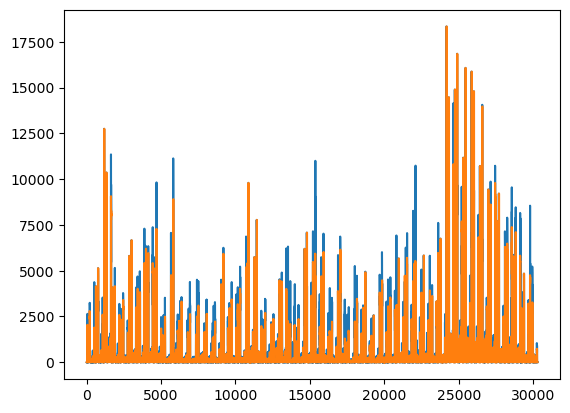

In [ ]:
# compare the estimated values with the observed values
plt.plot(lst)
plt.plot(plst)

$$RMSLE = \sqrt{ \frac{1}{n} \sum_{i=1}^n (\ln (1 + \hat{y}_i) - \ln (1 + y_i))^2} ,$$
where

$n$ is the total number of instances

$\hat{y_i}$ is the predicted value of the target for instance $i$

$y_i$ is the actual value of the target for instance $i$

In [165]:
def Root_Mean_Squared_Logarithmic_Error(y_true, y_pred):
    msle = tf.keras.losses.MeanSquaredLogarithmicError()
    return K.sqrt(msle(y_true, y_pred)) 

In [186]:
Root_Mean_Squared_Logarithmic_Error(lst, plst)

<tf.Tensor: shape=(), dtype=float32, numpy=0.54502314>